<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Portfolio Optimization using Mean Absolute Deviation](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/07.06-Portfolio-Optimization-using-Mean-Absolute-Deviation.ipynb) | [Contents](toc.ipynb) | [Log-Optimal Growth and the Kelly Criterion](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/07.08-Log-Optimal-Growth-and-the-Kelly-Criterion.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/07.07-MAD-Portfolio-Optimization.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/07.07-MAD-Portfolio-Optimization.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Portfolio Optimization

This [IPython notebook](http://ipython.org/notebook.html) demonstrates portfolio optimization using the Mean Absolute Deviation (MAD) criterion. A portion of these notes is adapted from [GLPK Wikibook tutorial on the subject](http://en.wikibooks.org/wiki/GLPK/Portfolio_Optimization) written by me.

J.C. Kantor (Kantor.1@nd.edu)

The latest version of this IPython notebook is available at [http://github.com/jckantor/CBE20255](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

## Investment Objectives

* Maximize returns
* Reduce Risk through diversification

## Why Diversify?

Investment portfolios are collections of investments that are managed for overall investment return.  Compared to investing all of your capital into a single asset, maintaining a portfolio of investments allows you to manage risk through diversification.

### Reduce Risk through Law of Large Numbers

Suppose there are a set of independent investment opportunities that will pay back between 0 and 300% of your original investment, and that all outcomes in that range are equally likely. You have $100,000 to invest.  Should you put it all in one opportunity?  Or should you spread it around?

Here we simulate the outcomes of 1000 trials where we place all the money into a sigle investment of $100,000.

Average Profit = $49126


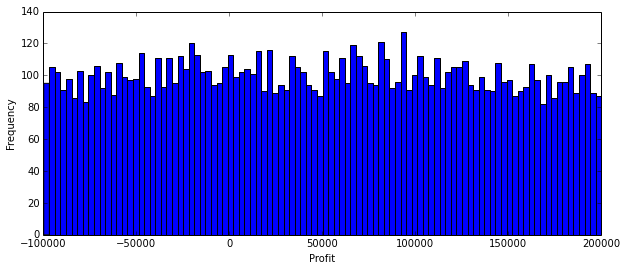

In [58]:
W0 = 100000.00

Ntrials = 10000
Profit = list()
for n in range(0,Ntrials):
    W1 = W0*random.uniform(0,3.00)
    Profit.append(W1 - W0)

figure(figsize=(10,4))
hist(Profit,bins=100);
xlabel('Profit')
ylabel('Frequency')

print "Average Profit = ${:.0f}".format(mean(Profit))

As you would expect, about 1/3 of the time there is a loss, and about 2/3 of the time there is a profit. Is this an acceptable investment outcome?

Let's see what happens if the $100,000 investment over a small number of equal sized investments.

Average Profit = $50177


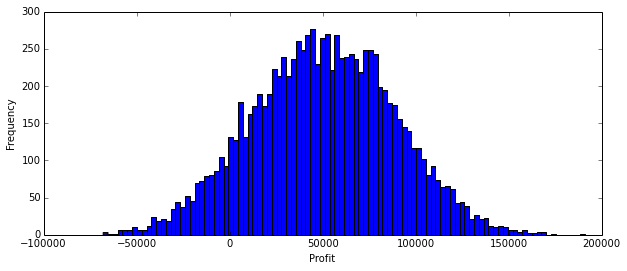

In [62]:
W0 = 100000.00

Ntrials = 10000
Ninvestments = 5

Profit = list()
for n in range(0,Ntrials):
    W1 = sum([(W0/Ninvestments)*random.uniform(0,3.00) for _ in range(0,Ninvestments)])
    Profit.append(W1-W0)

figure(figsize=(10,4))
hist(Profit,bins=100);
xlim(-W0,2*W0)
xlabel('Profit')
ylabel('Frequency')

print "Average Profit = ${:.0f}".format(mean(Profit))

Even a modest degree of diversification reduces downside risk.

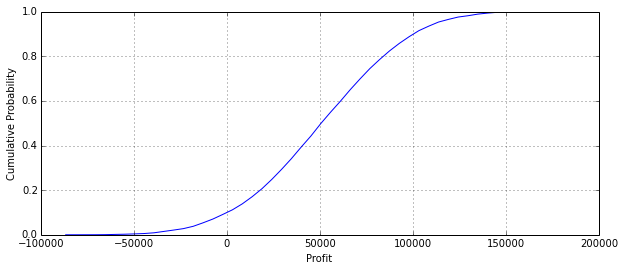

In [60]:
from statsmodels.distributions import ECDF

ecdf = ECDF(Profit)

x = linspace(min(Profit),max(Profit))

figure(figsize=(10,4))
plot(x,ecdf(x))
xlabel('Profit')
ylabel('Cumulative Probability')
grid();

## Select a Portfolio from a Set of Candidate Portfolios

In [15]:
djia = ['AXP','BA','CAT','CSCO','CVX','DD','DIS','GE', \
        'GS','HD','IBM','INTC','JNJ','JPM','KO','MCD', \
        'MMM','MRK','MSFT','NKE','PFE','PG','T','TRV', \
        'UNH','UTX','V','VZ','WMT','XOM']

small_portfolio = ['F','AAPL','XOM','PG','KO']

portfolio = small_portfolio
portfolio = djia

### Download Historical Data

In [55]:
import pandas as pd
import datetime
import pandas.io.data

end = datetime.datetime.today().date()
start = end - datetime.timedelta(3*365)

adjclose = pd.DataFrame()

for s in portfolio:
    data = pd.io.data.DataReader(s,"yahoo",start,end)
    print "{:5s} {:d}".format(s,len(data))
    adjclose[s] = data['Adj Close']
    
adjclose.plot(logy=True, legend=False, figsize=(10,6))
ylabel('Adjusted Close')
title('Adjusted Close for All Portfolio Assets')

AXP   754
BA    754
CAT   754
CSCO  754
CVX   754
DD    754
DIS   754
GE    754
GS    754
HD    754
IBM   754
INTC  754
JNJ   754
JPM   754
KO    754
MCD   754
MMM   754
MRK   754
MSFT  754
NKE   754
PFE   754
PG    754
T     754
TRV   754
UNH   754
UTX   754
V     754
VZ    754
WMT   754
XOM   754


### Equally Weighted Portfolio

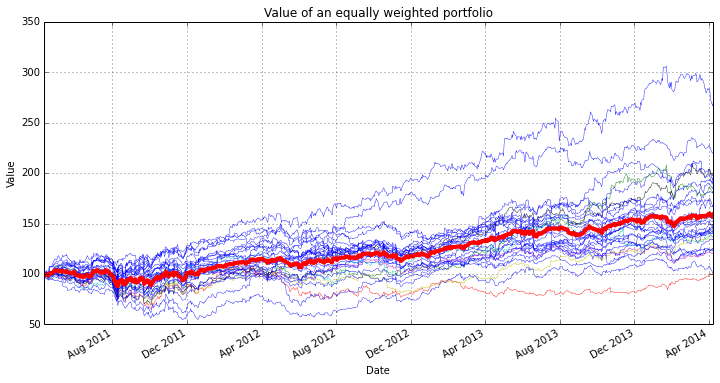

In [124]:
P_equal = pd.Series(0,index = adjclose.index)

for s in portfolio:
    P_equal += 100.0*adjclose[s]/adjclose[s][0]/len(portfolio)

figure(figsize=(12,6))

for s in portfolio:
    (100.0*adjclose[s]/adjclose[s][0]).plot(lw=0.4)

P_equal.plot(color='r',lw=4)
ylabel('Value');
title('Value of an equally weighted portfolio');


### Compute Component Returns

Arithmetic returns are required because subsequent calculations will be combining returns across components of a portfolio.

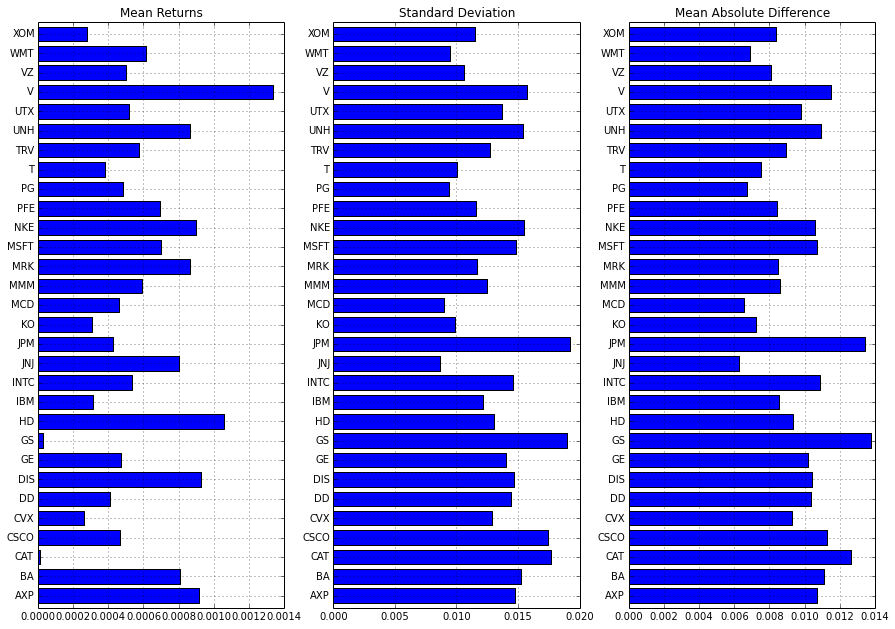

In [159]:
#returns = adjclose.diff()[1:]/adjclose[1:]
returns = log(adjclose/adjclose.shift(+1))
rmean = returns.mean()
mad = abs(returns-returns.mean()).mean()

# plug NaN holes due to missing data
for s in returns.columns:
    for t in returns.index:
        if isnan(returns[s][t]):
            returns[s][t] = rmean[s]

figure(figsize = (15,0.35*len(returns.columns)))
subplot(1,3,1)
returns.mean().plot(kind='barh')
title('Mean Returns');

subplot(1,3,2)
returns.std().plot(kind='barh')
title('Standard Deviation');

subplot(1,3,3)
abs(returns-returns.mean()).mean().plot(kind='barh')
title('Mean Absolute Difference');

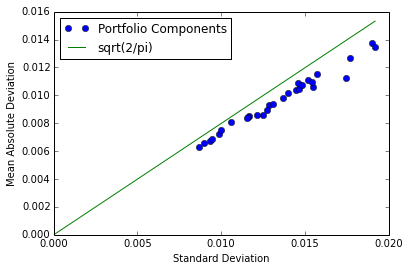

In [160]:
plot(returns.std(),abs(returns-returns.mean()).mean(),'o')
xlabel('Standard Deviation')
ylabel('Mean Absolute Deviation')

plot([0,returns.std().max()],[0,sqrt(2.0/pi)*returns.std().max()])
legend(['Portfolio Components','sqrt(2/pi)'],loc='best');

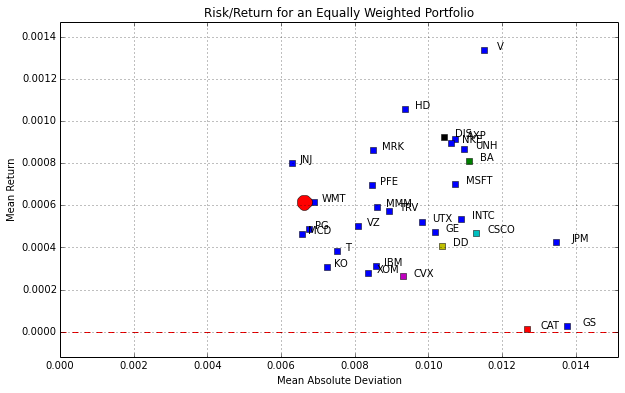

In [161]:
figure(figsize=(10,6))
for s in portfolio:
    plot(mad[s],rmean[s],'s')
    text(mad[s]*1.03,rmean[s],s)
    
axis([0, 1.1*max(mad), min([0,min(rmean)-.1*(max(rmean)-min(rmean))]), 1.1*max(rmean)])
ax = axis()
plot([ax[0],ax[1]],[0,0],'r--');

#R_equal = P_equal.diff()[1:]/P_equal[1:]
R_equal = log(P_equal/P_equal.shift(+1))
M_equal = abs(R_equal-R_equal.mean()).mean()

plot(M_equal,R_equal.mean(),'ro',ms=15)

title('Risk/Return for an Equally Weighted Portfolio')
xlabel('Mean Absolute Deviation')
ylabel('Mean Return')

grid();

## MAD Porfolio

The linear program is formulated and solved using the pulp package. 

In [117]:
!pip install pulp

Cleaning up...


The decision variables will be indexed by date/time.  The pandas dataframes containing the returns data are indexed by timestamps that include characters that cannot be used by the GLPK solver. Therefore we create a dictionary to translate the pandas timestamps to strings that can be read as members of a GLPK set. The strings denote seconds in the current epoch as defined by python.

In [163]:
t = {tstamp:"{:%s}".format(tstamp) for tstamp in returns.index}

In [193]:
import pulp

# mean absolute deviation for the portfolio
m = pulp.LpVariable('m', lowBound = 0)

# dictionary of portfolio weights
w = pulp.LpVariable.dicts('w', portfolio, lowBound = 0)

# dictionary of absolute deviations of portfolio returns
y = pulp.LpVariable.dicts('y', t.values(), lowBound = 0)
z = pulp.LpVariable.dicts('z', t.values(), lowBound = 0)

# create problem instance
lp = pulp.LpProblem('MAD Portfolio',pulp.LpMinimize)

# add objective
lp += m

# calculate mean absolute deviation of portfolio returns
lp += m == pulp.lpSum([(y[k] + z[k]) for k in t.values()])/float(len(t))

# relate the absolute deviations to deviations in the portfolio returns
for ts in returns.index:
    lp += y[t[ts]] - z[t[ts]] == pulp.lpSum([w[s]*(returns[s][ts]-returns[s].mean()) for s in portfolio]) 
    
# portfolio weights
lp += pulp.lpSum([w[s] for s in portfolio]) == 1.0

# bound on average portfolio return
lp += pulp.lpSum([w[s]*(returns[s].mean()) for s in portfolio]) >= 0*R_equal.mean()

lp.solve()
print pulp.LpStatus[lp.status]

Optimal


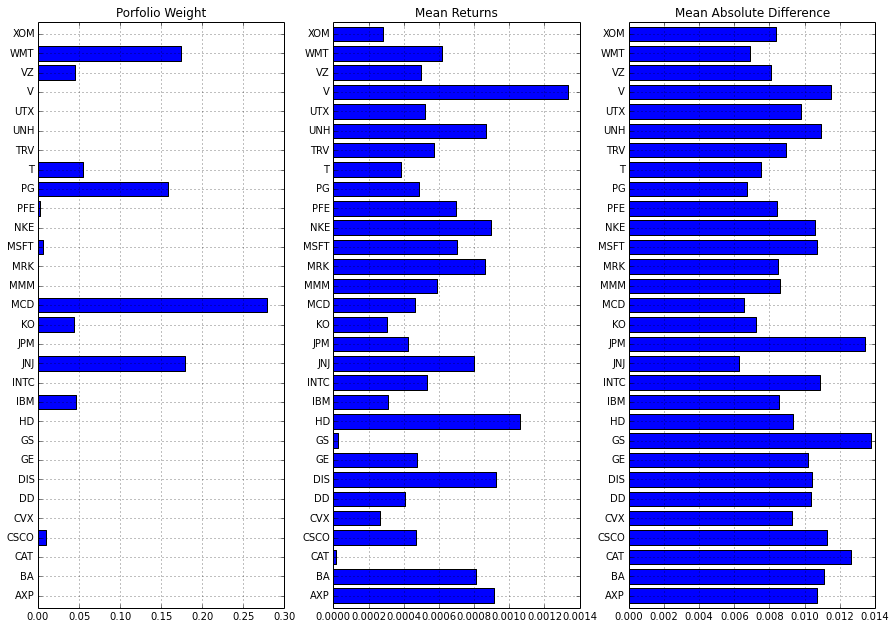

In [194]:
figure(figsize = (15,0.35*len(returns.columns)))

ws = pd.Series({s: w[s].varValue for s in portfolio},index=portfolio)

subplot(1,3,1)
ws.plot(kind='barh')
title('Porfolio Weight');

subplot(1,3,2)
returns.mean().plot(kind='barh')
title('Mean Returns');

subplot(1,3,3)
abs(returns-returns.mean()).mean().plot(kind='barh')
title('Mean Absolute Difference');

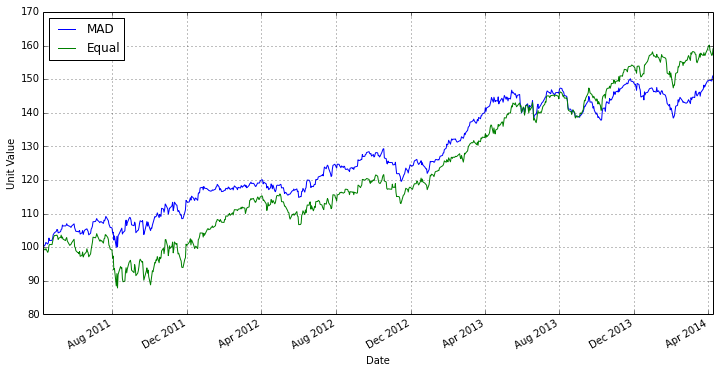

In [195]:
P_mad = pd.Series(0,index=adjclose.index)
for s in portfolio:
    P_mad += 100.0*ws[s]*adjclose[s]/adjclose[s][0]
    
figure(figsize=(12,6))
P_mad.plot()
P_equal.plot()
legend(['MAD','Equal'],loc='best')
ylabel('Unit Value')

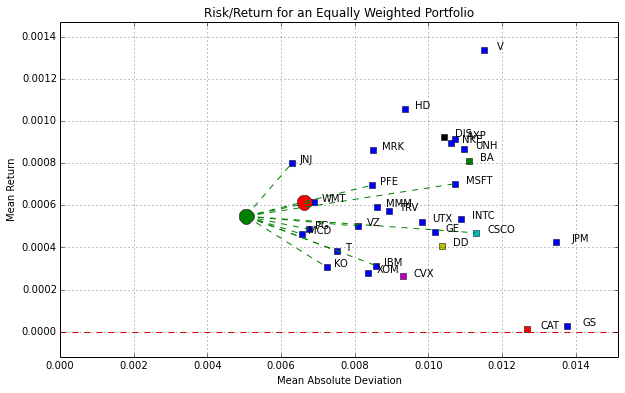

In [196]:
figure(figsize=(10,6))
for s in portfolio:
    plot(mad[s],rmean[s],'s')
    text(mad[s]*1.03,rmean[s],s)
    
axis([0, 1.1*max(mad), min([0,min(rmean)-.1*(max(rmean)-min(rmean))]), 1.1*max(rmean)])
ax = axis()
plot([ax[0],ax[1]],[0,0],'r--');

#R_equal = P_equal.diff()[1:]/P_equal[1:]
R_equal = log(P_equal/P_equal.shift(+1))
M_equal = abs(R_equal-R_equal.mean()).mean()

plot(M_equal,R_equal.mean(),'ro',ms=15)

#R_mad = P_mad.diff()[1:]/P_mad[1:]
R_mad = log(P_mad/P_mad.shift(+1))
M_mad = abs(R_mad-R_mad.mean()).mean()

for s in portfolio:
    if ws[s] >= 0.0001:
        plot([M_mad,mad[s]],[R_mad.mean(),rmean[s]],'g--')

plot(M_mad,R_mad.mean(),'go',ms=15)

title('Risk/Return for an Equally Weighted Portfolio')
xlabel('Mean Absolute Deviation')
ylabel('Mean Return')

grid();

## Problem 1: Solve for Dominating MAD Portfolio

In [94]:
lp = pulp.LpProblem('MAD Portfolio',pulp.LpMinimize)
lp += m    
lp += m == pulp.lpSum([(y[t] + z[t])/float(len(returns.index)) for t in tmap.values()])
lp += pulp.lpSum([w[s] for s in symbols]) == 1.0

for t in returns.index:
    lp += y[tsec[t]] - z[tsec[t]] == pulp.lpSum([w[s]*(returns[s][t]-rmean[s]) for s in symbols]) 
        
lp.solve()
m_min = m.varValue
m_min

NameError: name 'tmap' is not defined

In [95]:
# Solve for maximum return at minimum MAD

r = pulp.LpVariable('r',lowBound = 0)

lp = pulp.LpProblem('MAD Portfolio',pulp.LpMaximize)
lp += r
lp += r == pulp.lpSum([w[s]*rmean[s] for s in symbols])
lp += m_min == pulp.lpSum([(y[t] + z[t])/float(len(returns.index)) for t in tmap.values()])
lp += pulp.lpSum([w[s] for s in symbols]) == 1.0
for t in returns.index:
    lp += y[tsec[t]] - z[tsec[t]] == pulp.lpSum([w[s]*(returns[s][t]-rmean[s]) for s in symbols]) 
        
lp.solve()
r_min = r.varValue
w_min = pd.Series([pulp.value(w[s]) for s in symbols], index= symbols)

NameError: name 'symbols' is not defined

<!--NAVIGATION-->
< [Portfolio Optimization using Mean Absolute Deviation](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/07.06-Portfolio-Optimization-using-Mean-Absolute-Deviation.ipynb) | [Contents](toc.ipynb) | [Log-Optimal Growth and the Kelly Criterion](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/07.08-Log-Optimal-Growth-and-the-Kelly-Criterion.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/07.07-MAD-Portfolio-Optimization.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/07.07-MAD-Portfolio-Optimization.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>